# Quickstart: Collisional Ionization Equilibrium

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"RHS of e- number density equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
RHS of e- number density equation: -1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)

system.subprocesses

[Collisional Ionization of H,
 Collisional Ionization of He,
 Collisional Ionization of He+,
 Gas-phase recombination of H+,
 Gas-phase recombination of He+,
 Gas-phase recombination of He++]

# Solving thermochemical equilibrum

In [8]:
from pism.processes import FreeFreeEmission, LineCoolingSimple
system +=  sum([FreeFreeEmission(i) for i in ("H+", "He+", "He++")]) + sum([LineCoolingSimple(i) for i in ("H", "He+",)])
system.heat += 1e-27 * sp.Symbol("n_Htot")
system.network["e-"] += 1e-16 * sp.Symbol("n_Htot")
system.network["H+"] += 1e-16 * sp.Symbol("n_Htot")
system.network["H"] -= 1e-16 * sp.Symbol("n_Htot")
T = sp.Symbol("T")

# C+ cooling - assumes 
system.heat -= 1e-27 * sp.Symbol("n_Htot") * sp.exp(-91.211 / T) * (4890 / sp.sqrt(T) *  (1e-4 * sp.Symbol("n_H")) + 0.47 * T**0.15 * sp.Symbol("n_Htot"))
ngrid = np.logspace(-3,3,10**4)
Ygrid = 0.24*np.ones_like(ngrid)

knowns = {"n_Htot": ngrid, "Y": Ygrid} #, "n_He": 0.24/(4-4*0.24)*ngrid, "n_He+": np.zeros_like(ngrid)} #, "Z_C": np.ones_like(ngrid), "n_C+": ngrid * 1e-4}


guesses = {
    "T": 100. * np.ones_like(ngrid),
    "H": ngrid*0.99,
    "He": 0.24/(4-4*0.24)*ngrid*0.99,
    "He+": 0.24/(4-4*0.24)*ngrid*0.01
}

sol = system.steadystate(knowns, guesses,tol=1e-3,input_abundances=False, output_abundances=True,careful_steps=30)
print(sol)

{'He': Array([0.07894589, 0.0789459 , 0.07894589, ..., 0.07894737, 0.07894737,
       0.07894737], dtype=float32), 'H': Array([0.31103617, 0.31155923, 0.3120818 , ..., 0.99991643, 0.9999165 ,
       0.99991655], dtype=float32), 'He+': Array([1.4756913e-06, 1.4738829e-06, 1.4720949e-06, ..., 1.4707909e-09,
       1.4747827e-09, 1.4709340e-09], dtype=float32), 'T': Array([9924.148   , 9922.254   , 9920.363   , ...,   13.580868,
         13.578094,   13.575319], dtype=float32), 'H+': Array([6.8896383e-01, 6.8844080e-01, 6.8791813e-01, ..., 8.3543535e-05,
       8.3489300e-05, 8.3435058e-05], dtype=float32), 'e-': Array([6.8896526e-01, 6.8844223e-01, 6.8791962e-01, ..., 8.3542065e-05,
       8.3487823e-05, 8.3418330e-05], dtype=float32), 'He++': Array([ 1.3280487e-09, -6.1687522e-09,  8.4841612e-10, ...,
       -1.4707909e-09, -1.4747827e-09, -9.1003285e-09], dtype=float32)}


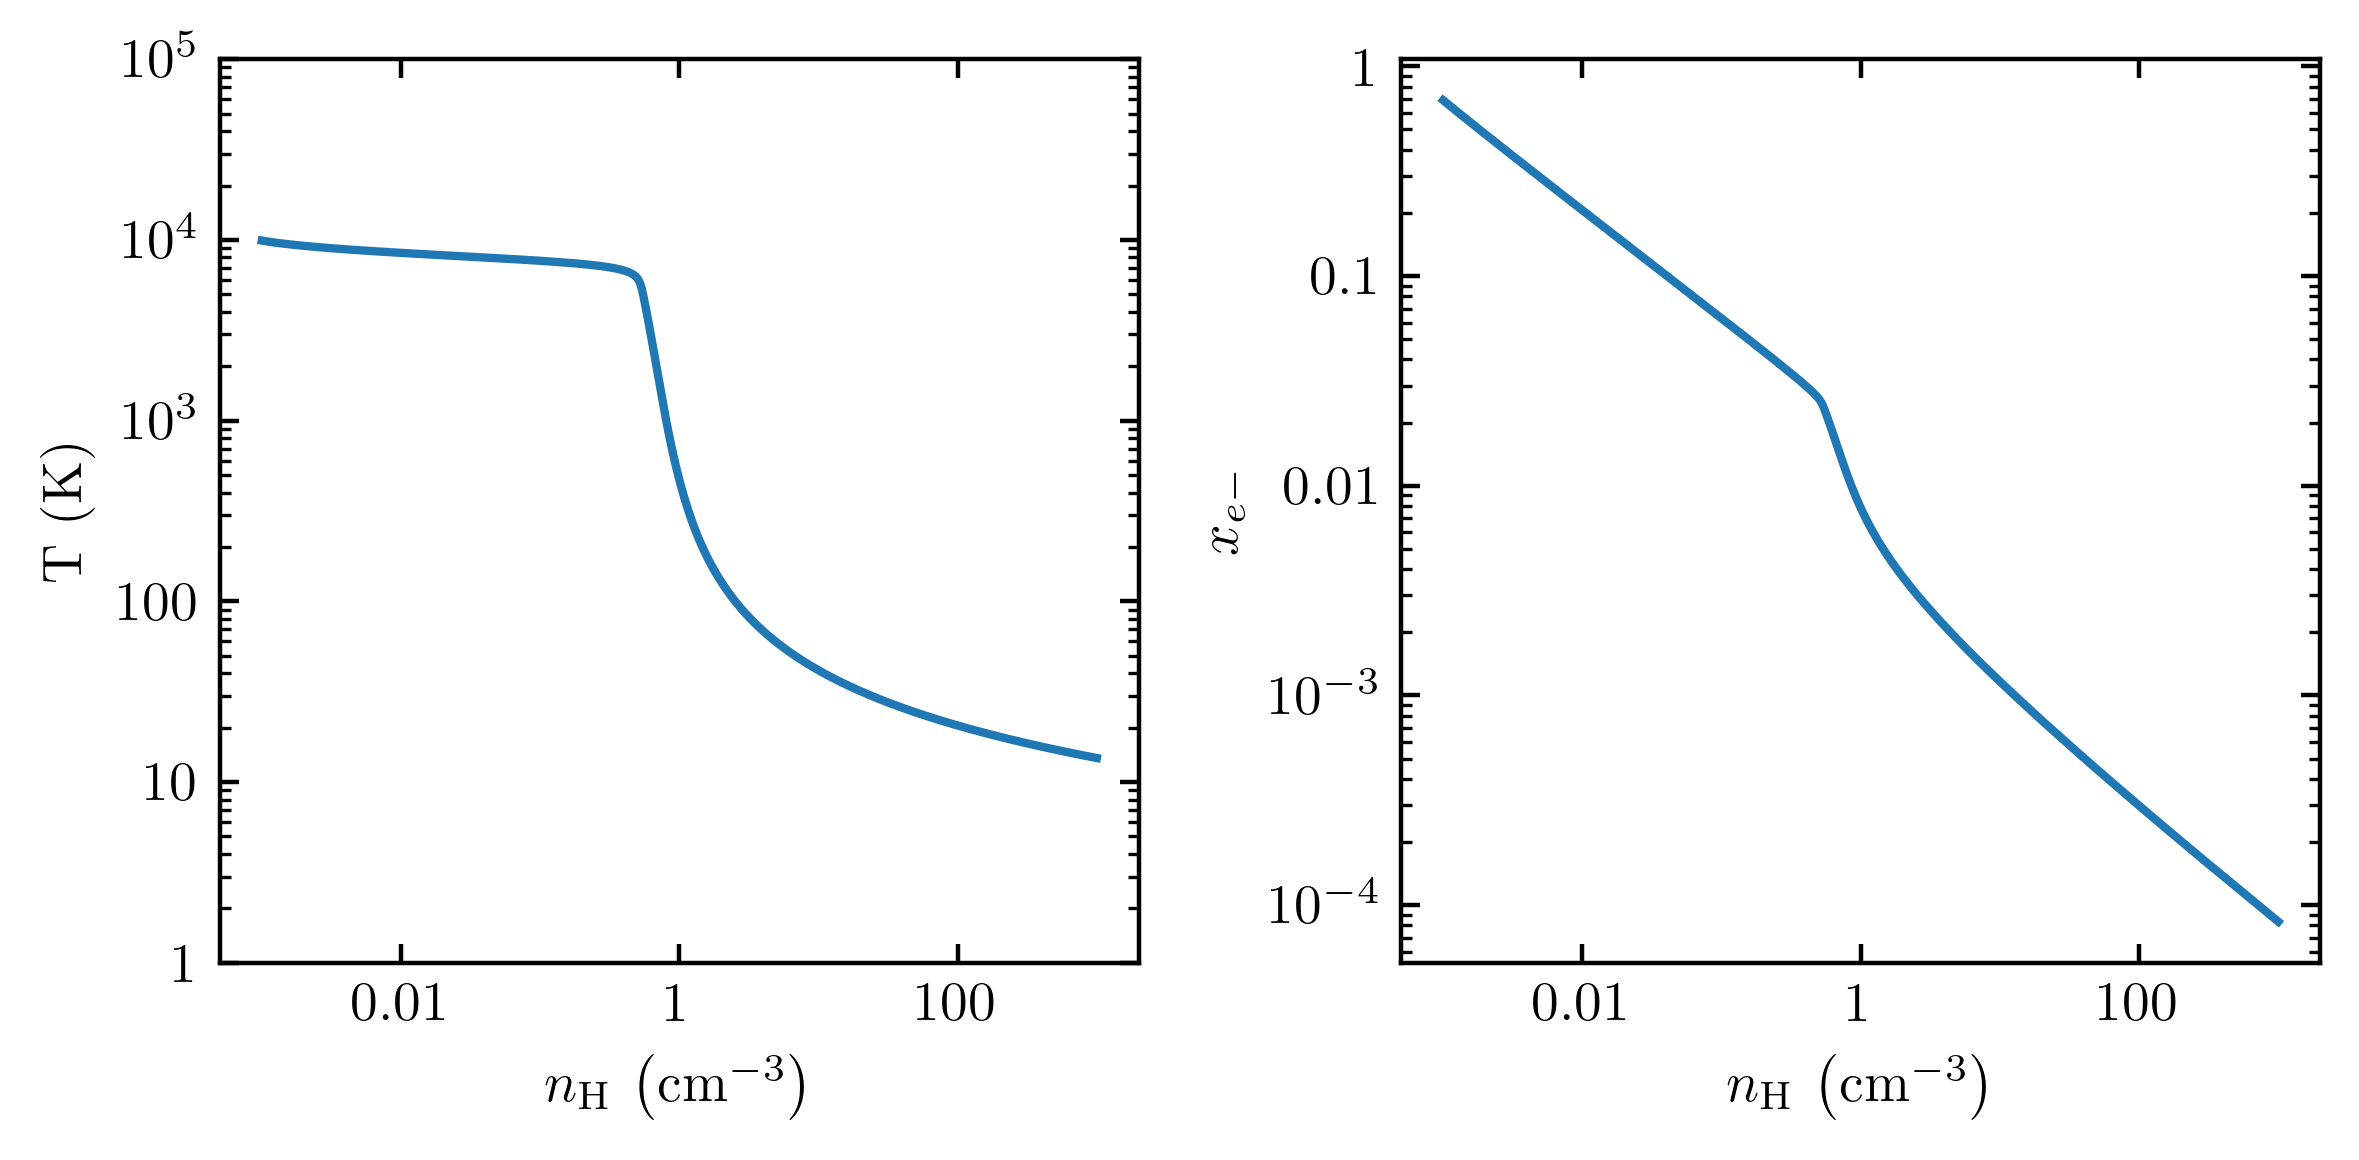

In [13]:
fig, ax = plt.subplots(1,2,sharex=True,figsize=(6,3))
ax[0].loglog(ngrid,sol["T"])
ax[1].loglog(ngrid,sol["e-"])
ax[0].set_xlabel(r"$n_{\rm H}\,\left(\rm cm^{-3}\right)$")
ax[1].set_xlabel(r"$n_{\rm H}\,\left(\rm cm^{-3}\right)$")
ax[0].set_ylabel("T (K)")
ax[1].set_ylabel(r"$x_{e-}$")
ax[0].set_ylim(1,1e5)
fig.tight_layout()